## Setup, Data Loading

Running locally, reading from the current directory.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48000 entries, 0 to 47999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      48000 non-null  int64 
 1   text    48000 non-null  object
 2   label   48000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.1+ MB
label
0    25798
1    22015
2      187
Name: count, dtype: int64


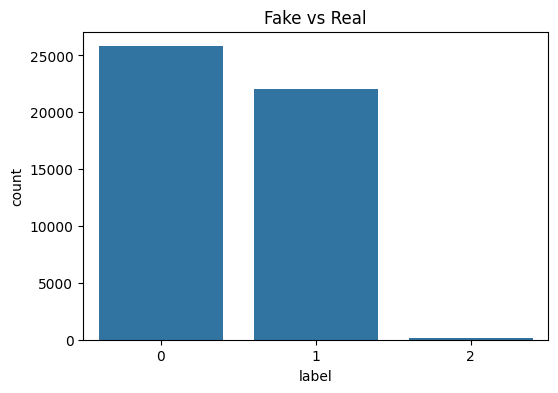

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
# conifguration 
pd.set_option('display.max_columns', 200)

# Load Data
try:
    if 'KAGGLE_KERNEL_RUN_TYPE' in os.environ:
        print("Running on Kaggle, reading from Kaggle's input directory.")
        train_df = pd.read_csv('/kaggle/input/depi-r-3-competition-1/xy_train.csv')
        test_df = pd.read_csv('/kaggle/input/depi-r-3-competition-1/x_test.csv')
        sample_submission_df = pd.read_csv('/kaggle/input/depi-r-3-competition-1/sample_submission.csv')
    else:
        print("Running locally, reading from the current directory.")
        train_df = pd.read_csv('xy_train.csv')
        test_df = pd.read_csv('x_test.csv')
        sample_submission_df = pd.read_csv('sample_submission.csv')
except FileNotFoundError:
    print("File issue!!")

train_df.info()

#label distribution
print(train_df['label'].value_counts())

#let's see the distribution
plt.figure(figsize=(6,4))
sns.countplot(x='label', data = train_df)
plt.title("Fake vs Real")
plt.xlabel('label')
plt.ylabel('count')
plt.show()

In [44]:
train_df.head()

,ID,text,label
0,0,Americans Aren't Sure If Flight 370 Vanished T...,1
1,1,Pope Leo X offering indulgences to sinners sho...,0
2,2,News: 5 Uplifting Hypotheticals Of What Could ...,0
3,3,George W. Bush and Jeb Bush at a campaign stop...,0
4,4,The WADA requesting their fair share from Lanc...,0


In [45]:
test_df.head()

,ID,text
0,0,Local soccer club ditch shirt sponsorship deal...
1,1,What is this weird metal thing in the mail fro...
2,2,Donald Trump Jr reportedly told in email of Ru...
3,3,Satanist prayer is held in Alaskan government ...
4,4,There's A Spectacular Error In The Background ...


In [46]:
sample_submission_df.head()

,ID,label
0,0,1
1,1,0
2,2,1
3,3,0
4,4,0


## Data Cleaning

In [47]:
# since we found a label=2 we should remove it
train_df = train_df[train_df['label'] != 2]


In [48]:
print(train_df.info())
print(train_df['label'].value_counts())

<class 'pandas.core.frame.DataFrame'>
Index: 47813 entries, 0 to 47999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      47813 non-null  int64 
 1   text    47813 non-null  object
 2   label   47813 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.5+ MB
None
label
0    25798
1    22015
Name: count, dtype: int64


## Answering Key Questions

### 1. What is the difference between Character n-gram and Word n-gram? Which one is more affected by the OOV (Out-of-Vocabulary) issue?

* **Word n-grams** are continous segments of words in a given sentence, 
let's define define a sentence: khaled love banana.
a words n-gram of n=2 will look like this: [khaled love][love banana]

* **Char n-gram** are continous segments of characters in a given sentence,
let's trace it on "khaled for n=3
it should look like this: [khal][hal][ale][led]

* **Which one is more affected by the OOV???** simply the anwer is the word n-gram, it makes sense as the letter n-gram for example in english is just 26 letters but the words in the dictionary?? i doubt you know them xD

### 2. What is the difference between stop word removal and stemming? Are these techniques language-dependent?

* **Stop words removal** is just the process of removing popular stop words like "a","the",etc..
* **Stemming** is the process of transforming a word to it's root, for example "playing" ==> "play"
* **Lang Dependence?** yes due to the stemming rules and what wrord endings to move and what to keep so lang is imp here

### 3. Is tokenization language-dependent? Why?

* **Yes**, for example the word boundaries in English (whitespaces) need carefull tokenization while in lang like chinese not boundaries at all

### 4. What is the difference between Count Vectorizer and TF-IDF Vectorizer? Is it feasible to use all possible n-grams? How should they be selected?

* **CountVectorizer**: matrix of frequencies, each row for docs and each col for tokens and the cells ==> the count of each token in that doc.

* **TF-IDF Vectorizer**: matrix of frequencies but in aaddition to weighting.
    * TF: same as the CountVectorizer, measure the freq of a word in a doc
    * IDF: How important the term is, low weights for high freq words while high weight for low freq words.
    * TF-IDF: multiplication of TF and IDF.
    * TF-IDF ==> help to identify words that are freq in specific doc but rare across all docs.


* **No it is not Feasible to use all n-grams**, simply for large vocab it will produce very high dimension vector which will make the model very slow

* **How to select N-grams? **
    * **Limit the n**: use uni,bi or try grams, 1 <= n <= 3
    * **Max features**: limit the vocab to be used, use the most frequent ones.
    * ignore terms that have doc freq lower than a min_df or higher than max_df you set


## Modeling

** Model Exploration (Trials)

* Trial 1 | Logistic Regression

In [49]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

In [50]:
X = train_df['text']
y = train_df['label']


X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Train set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")

Train set size: 38250
Validation set size: 9563


In [51]:
from sklearn.linear_model import LogisticRegression

#create the pipeline for the Tfidf + Logistic Reg
logistic_pipeline = Pipeline(
    [
        ('tfidf', TfidfVectorizer(stop_words='english')),
        ('model', LogisticRegression(random_state=42, solver='liblinear'))
    ]
)

print("\nTraining the model....")
logistic_pipeline.fit(X_train, y_train)
print(".....Taining complete.....")

y_pred = logistic_pipeline.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print(f"Trial 1 | Logistic Regression | acc = {accuracy:.4f}")


Training the model....
.....Taining complete.....
Trial 1 | Logistic Regression | acc = 0.8079


* Trial 2 | Naive Bayes

In [52]:
from sklearn.naive_bayes import MultinomialNB

naive_bayes_pipeline = Pipeline(
    [
        ('tfidf', TfidfVectorizer(stop_words='english')),
        ('model', MultinomialNB())
    ]
)

print("\nTraining the model....")
naive_bayes_pipeline.fit(X_train, y_train)
print(".....Taining complete.....")

y_pred = naive_bayes_pipeline.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print(f"Trial 2 | Naive Bayes | acc = {accuracy:.4f}")



Training the model....
.....Taining complete.....
Trial 2 | Naive Bayes | acc = 0.7858


* Trial 3 XGboost

In [53]:
import xgboost as xgb

xgb_pipeline = Pipeline(
    [
        ('tfidf', TfidfVectorizer(stop_words='english')),
        ('model', xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42))
    ]
)

print("\nTraining the model....")
xgb_pipeline.fit(X_train, y_train)
print(".....Taining complete.....")

y_pred = xgb_pipeline.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print(f"Trial 3 | XGBoost | acc = {accuracy:.4f}")


Training the model....


c:\Users\KH&H\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:48:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


.....Taining complete.....
Trial 3 | XGBoost | acc = 0.7435
